# Initialisation

In [199]:
from IPython.core.display import HTML
HTML('<style> .container{ width:90%; } </style>')

Standard libraries:
- Scientific computing (numpy)
- Data analysis (pandas)
- Plotting (matplotlib, seaborn)
- Machine learning (scikit-learn)
- Gradient-boosted trees (xgboost)
- Deep learning (tensorflow, keras, keras_metrics)

In [249]:
import sys
!{sys.executable} -m pip install --quiet numpy
!{sys.executable} -m pip install --quiet pandas
!{sys.executable} -m pip install --quiet matplotlib
!{sys.executable} -m pip install --quiet seaborn
!{sys.executable} -m pip install --quiet sklearn
!{sys.executable} -m pip install --quiet xgboost
!{sys.executable} -m pip install --quiet tensorflow
!{sys.executable} -m pip install --quiet keras
!{sys.executable} -m pip install --quiet keras_metrics

In [64]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Data Loading

Loading CVS file onto pandas dataframe, a tabular data structure.

Printing first few rows, the shape of data (rows, column), the data types, and some basic analysis of the numeric features

In [65]:
col_names = [
    'age', 
    'workclass', 
    'fnlwgt', 
    'education', 
    'education-num', 
    'marital-status', 
    'occupation', 
    'relationship',
    'race', 
    'sex', 
    'capital-gain', 
    'capital-loss', 
    'hours-per-week', 
    'native-country', 
    'income',
]

df = pd.read_csv('data/census_income.csv', names=col_names, skipinitialspace=True, na_values=['?'])
df.head(10)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
5,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K
6,49,Private,160187,9th,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,0,16,Jamaica,<=50K
7,52,Self-emp-not-inc,209642,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States,>50K
8,31,Private,45781,Masters,14,Never-married,Prof-specialty,Not-in-family,White,Female,14084,0,50,United-States,>50K
9,42,Private,159449,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178,0,40,United-States,>50K


In [66]:
df.shape

(48842, 15)

In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
age               48842 non-null int64
workclass         46043 non-null object
fnlwgt            48842 non-null int64
education         48842 non-null object
education-num     48842 non-null int64
marital-status    48842 non-null object
occupation        46033 non-null object
relationship      48842 non-null object
race              48842 non-null object
sex               48842 non-null object
capital-gain      48842 non-null int64
capital-loss      48842 non-null int64
hours-per-week    48842 non-null int64
native-country    47985 non-null object
income            48842 non-null object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


In [68]:
df.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,48842.000000,4.884200e+04,48842.000000,48842.000000,48842.000000,48842.000000
mean,38.643585,1.896641e+05,10.078089,1079.067626,87.502314,40.422382
std,13.710510,1.056040e+05,2.570973,7452.019058,403.004552,12.391444
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.175505e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.781445e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.376420e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000


Based on the data description available at https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names, 
feature 'fnlwgt' does not add any useful information, so it is best to remove.

Feature "education" is also redundant because "education-num" encodes the same information with numerical values.

In [69]:
df = df.drop('fnlwgt', axis=1)
df = df.drop('education', axis=1)


# Exploratory Data Analysis

Check whether numeric features are correlated. Since they are not, all of them bring new relevant information

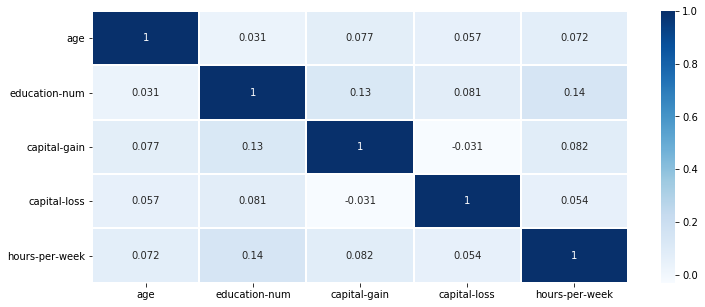

In [70]:
plt.figure(figsize=(12,5))
sns.heatmap(df.corr(), annot=True, cmap='Blues', linecolor='white', linewidths=1)
plt.show()

Plot data to understand it, determine whether any features look strongly correlated with high or low income

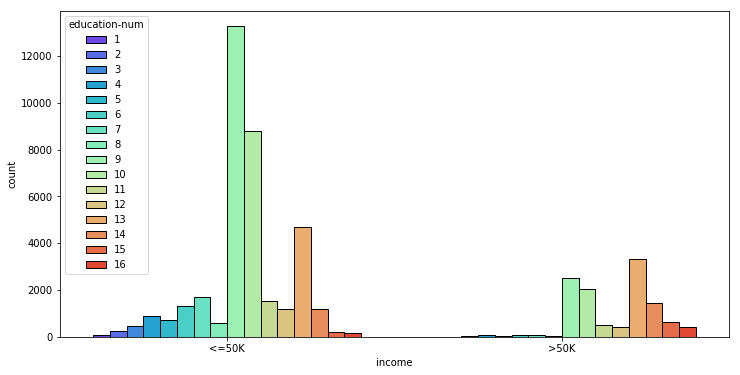

In [71]:
plt.figure(figsize=(12,6))
sns.countplot(x = df['income'], hue = df['education-num'], palette = 'rainbow', edgecolor = [(0,0,0), (0,0,0)])
plt.show()

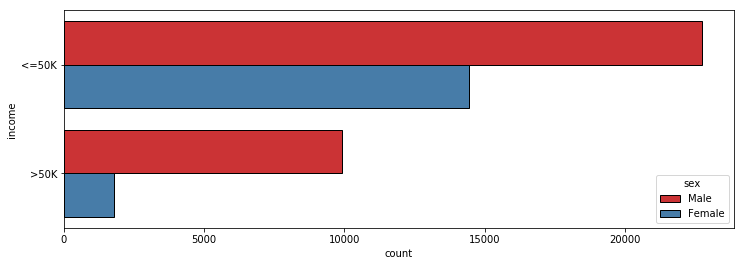

In [72]:
plt.figure(figsize=(12,4))
sns.countplot(y = df['income'], hue = df['sex'], palette = 'Set1', edgecolor = [(0,0,0), (0,0,0)])
plt.show()

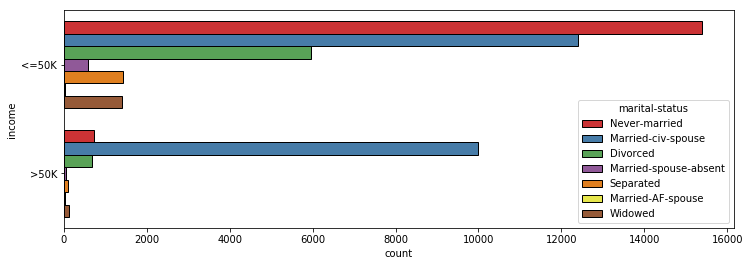

In [73]:
plt.figure(figsize=(12,4))
sns.countplot(y = df['income'], hue = df['marital-status'], palette = 'Set1', edgecolor = [(0,0,0), (0,0,0)])
plt.show()

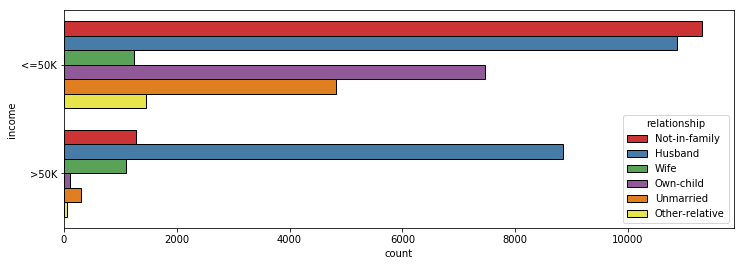

In [74]:
plt.figure(figsize=(12,4))
sns.countplot(y = df['income'], hue = df['relationship'], palette = 'Set1', edgecolor = [(0,0,0), (0,0,0)])
plt.show()

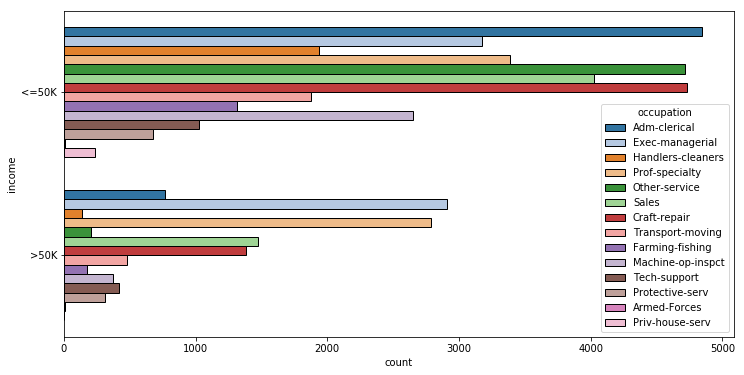

In [75]:
plt.figure(figsize=(12,6))
sns.countplot(y = df['income'], hue = df['occupation'], palette = 'tab20', edgecolor = [(0,0,0), (0,0,0)])
plt.show()

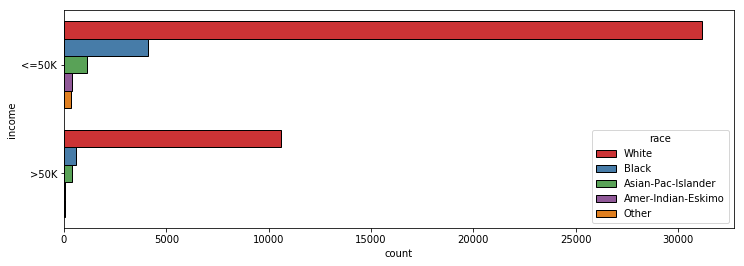

In [76]:
plt.figure(figsize=(12,4))
sns.countplot(y = df['income'], hue = df['race'], palette = 'Set1', edgecolor = [(0,0,0), (0,0,0)])
plt.show()

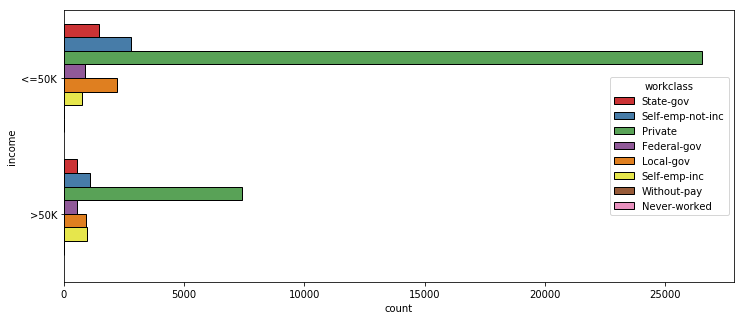

In [77]:
plt.figure(figsize=(12,5))
sns.countplot(y = df['income'], hue = df['workclass'], palette = 'Set1', edgecolor = [(0,0,0), (0,0,0)])
plt.show()

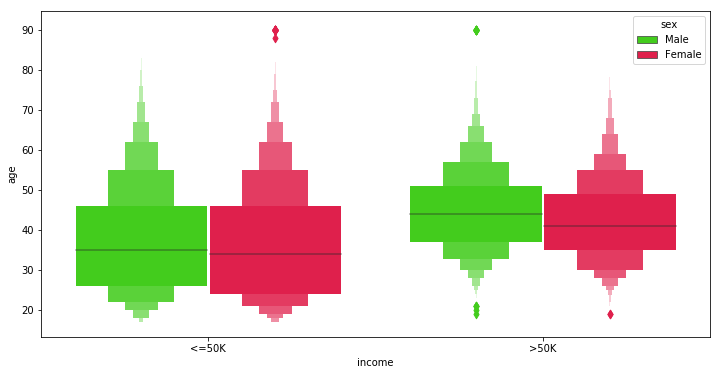

In [78]:
plt.figure(figsize=(12, 6))
sns.boxenplot(x='income', y='age', data=df, hue='sex', palette = 'prism')
plt.show()

# Dealing with NULLs

In [79]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 13 columns):
age               48842 non-null int64
workclass         46043 non-null object
education-num     48842 non-null int64
marital-status    48842 non-null object
occupation        46033 non-null object
relationship      48842 non-null object
race              48842 non-null object
sex               48842 non-null object
capital-gain      48842 non-null int64
capital-loss      48842 non-null int64
hours-per-week    48842 non-null int64
native-country    47985 non-null object
income            48842 non-null object
dtypes: int64(5), object(8)
memory usage: 4.8+ MB


In [80]:
df[df.isnull().any(axis=1)]

,age,workclass,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
14,40,Private,11,Married-civ-spouse,Craft-repair,Husband,Asian-Pac-Islander,Male,0,0,40,NaN,>50K
27,54,NaN,10,Married-civ-spouse,NaN,Husband,Asian-Pac-Islander,Male,0,0,60,South,>50K
38,31,Private,10,Married-civ-spouse,Sales,Husband,White,Male,0,0,38,NaN,>50K
51,18,Private,9,Never-married,Other-service,Own-child,White,Female,0,0,30,NaN,<=50K
61,32,NaN,4,Married-spouse-absent,NaN,Not-in-family,White,Male,0,0,40,NaN,<=50K
69,25,NaN,10,Never-married,NaN,Own-child,White,Male,0,0,40,United-States,<=50K
77,67,NaN,6,Married-civ-spouse,NaN,Husband,White,Male,0,0,2,United-States,<=50K
93,30,Private,9,Married-civ-spouse,Sales,Wife,Asian-Pac-Islander,Female,0,1573,35,NaN,<=50K
106,17,NaN,6,Never-married,NaN,Own-child,White,Female,34095,0,32,United-States,<=50K
128,35,NaN,9,Married-civ-spouse,NaN,Husband,White,Male,0,0,40,United-States,<=50K


In [81]:
df['native-country'].value_counts().head(10)

United-States    43832
Mexico             951
Philippines        295
Germany            206
Puerto-Rico        184
Canada             182
El-Salvador        155
India              151
Cuba               138
England            127
Name: native-country, dtype: int64

In [82]:
df['native-country'].fillna('United-States', inplace=True)
df[df['native-country'].isnull()]

,age,workclass,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income


In [83]:
df['workclass'].value_counts()

Private             33906
Self-emp-not-inc     3862
Local-gov            3136
State-gov            1981
Self-emp-inc         1695
Federal-gov          1432
Without-pay            21
Never-worked           10
Name: workclass, dtype: int64

In [84]:
df['workclass'].fillna('Private', inplace=True)
df[df['workclass'].isnull()]

,age,workclass,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income


In [85]:
df['occupation'].value_counts()

Prof-specialty       6172
Craft-repair         6112
Exec-managerial      6086
Adm-clerical         5611
Sales                5504
Other-service        4923
Machine-op-inspct    3022
Transport-moving     2355
Handlers-cleaners    2072
Farming-fishing      1490
Tech-support         1446
Protective-serv       983
Priv-house-serv       242
Armed-Forces           15
Name: occupation, dtype: int64

In [86]:
df[df.isnull().any(axis=1)]

,age,workclass,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
27,54,Private,10,Married-civ-spouse,NaN,Husband,Asian-Pac-Islander,Male,0,0,60,South,>50K
61,32,Private,4,Married-spouse-absent,NaN,Not-in-family,White,Male,0,0,40,United-States,<=50K
69,25,Private,10,Never-married,NaN,Own-child,White,Male,0,0,40,United-States,<=50K
77,67,Private,6,Married-civ-spouse,NaN,Husband,White,Male,0,0,2,United-States,<=50K
106,17,Private,6,Never-married,NaN,Own-child,White,Female,34095,0,32,United-States,<=50K
128,35,Private,9,Married-civ-spouse,NaN,Husband,White,Male,0,0,40,United-States,<=50K
149,43,Private,10,Divorced,NaN,Not-in-family,White,Female,0,0,40,United-States,<=50K
154,52,Private,9,Divorced,NaN,Not-in-family,White,Male,0,0,45,United-States,>50K
160,68,Private,2,Divorced,NaN,Not-in-family,White,Female,0,0,20,United-States,<=50K
187,53,Private,13,Divorced,NaN,Not-in-family,White,Female,0,0,50,United-States,<=50K


In [87]:
df.dropna(inplace=True)
df[pd.isnull(df).any(axis=1)]

,age,workclass,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income


# Transforming Categorical Features

In [88]:
tdf = pd.get_dummies(df, columns=[
    'workclass', 
    'marital-status', 
    'occupation', 
    'relationship', 
    'race', 
    'sex',
    'native-country',
], drop_first=True)

In [254]:
tdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46033 entries, 0 to 48841
Data columns (total 81 columns):
age                                          46033 non-null int64
education-num                                46033 non-null int64
capital-gain                                 46033 non-null int64
capital-loss                                 46033 non-null int64
hours-per-week                               46033 non-null int64
income                                       46033 non-null object
workclass_Local-gov                          46033 non-null uint8
workclass_Private                            46033 non-null uint8
workclass_Self-emp-inc                       46033 non-null uint8
workclass_Self-emp-not-inc                   46033 non-null uint8
workclass_State-gov                          46033 non-null uint8
workclass_Without-pay                        46033 non-null uint8
marital-status_Married-AF-spouse             46033 non-null uint8
marital-status_Married-civ-spous

# Train-Test Split

In [255]:
from sklearn.model_selection import train_test_split

Split the dataframe into features (X) and labels(y)

In [256]:
X = tdf.drop('income', axis=1)
y = tdf['income']

Put aside 20% of features to test, train with remaining 80%

In [257]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Feature Selection

Now our problem is we have 81 variables to predict a single one. Many of these variables will have absolutely no impact on the income of our citizens, but will add a lot of useless noise to the regression, and may even make it not converge

We use a little trick called SelectKBest that will give us the k=30 best features based on a standard statistical score. In this case, we use Pearson's Chi Squared test.

In [258]:
from sklearn.feature_selection import SelectKBest, chi2

In [259]:
feature_select = SelectKBest(chi2, k=30)
feature_select.fit(X_train, y_train)

SelectKBest(k=30, score_func=<function chi2 at 0x0000025347D28840>)

In [260]:
uni_features = list(zip(feature_select.scores_, X_train.columns))
sorted(uni_features, reverse=True)[0:30]

[(97439756.56032205, 'capital-gain'),
 (1448406.7428189695, 'capital-loss'),
 (9462.601460382255, 'age'),
 (6839.383931709429, 'hours-per-week'),
 (3914.86662396489, 'marital-status_Married-civ-spouse'),
 (2668.3940945167124, 'education-num'),
 (2544.771381963572, 'marital-status_Never-married'),
 (1559.7925775095136, 'relationship_Own-child'),
 (1355.1683313345168, 'occupation_Exec-managerial'),
 (1143.1292793482025, 'occupation_Prof-specialty'),
 (1029.789840010216, 'relationship_Not-in-family'),
 (884.9017854358567, 'occupation_Other-service'),
 (713.2319103143001, 'relationship_Unmarried'),
 (637.450705031886, 'workclass_Self-emp-inc'),
 (552.6279906149472, 'sex_Male'),
 (519.8162652164983, 'relationship_Wife'),
 (291.0938486875709, 'occupation_Handlers-cleaners'),
 (282.96805622430776, 'race_Black'),
 (257.5673573513839, 'relationship_Other-relative'),
 (214.5843814737926, 'occupation_Machine-op-inspct'),
 (190.33510893132097, 'marital-status_Separated'),
 (143.99203369161523, 'ma

In [261]:
X_train_1 = feature_select.transform(X_train)
X_test_1 = feature_select.transform(X_test)

# Utility Functions

In [262]:
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, classification_report, roc_auc_score, roc_curve

In [263]:
def plot_metrics(classifier, full_data = False):
    prediction = classifier.predict(X_test if full_data else X_test_1)
    print('Accuracy is: %0.3f' % accuracy_score(y_test, prediction))
    print('F1 Score is: %0.3f' % f1_score(y_test, prediction, pos_label=">50K"))
    print(classification_report(y_test, prediction))
    sns.heatmap(confusion_matrix(y_test, prediction), annot=True, fmt="d")
    plt.show()

In [276]:
def plot_roc_curve(classifier, full_data = False):
    fpr, tpr, thresholds = roc_curve(y_test, classifier.predict_proba(X_test if full_data else X_test_1)[:,1], pos_label=">50K")
    plt.figure()
    plt.plot(fpr, tpr, label='%s (area = %0.3f)' % (type(classifier).__name__, 
                                                    roc_auc_score(y_test, classifier.predict(X_test if full_data else X_test_1)==">50K")))
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([-0.05, 1.05])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate = 1 - Specificity')
    plt.ylabel('True Positive Rate = Recall')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

In [277]:
def plot_cap_curve(classifier, full_data = False):
    from scipy import integrate
    y_preds_proba = classifier.predict_proba(X_test if full_data else X_test_1)[:,1]
    y_values = y_test==">50K"
    num_pos_obs = np.sum(y_values)
    num_count = len(y_values)
    rate_pos_obs = float(num_pos_obs) / float(num_count)
    ideal = pd.DataFrame({'x':[0,rate_pos_obs,1],'y':[0,1,1]})
    xx = np.arange(num_count) / float(num_count - 1)
    
    y_cap = np.c_[y_values,y_preds_proba]
    y_cap_df_s = pd.DataFrame(data=y_cap)
    y_cap_df_s = y_cap_df_s.sort_values([1], ascending=False).reset_index(level = y_cap_df_s.index.names, drop=True)
    
    #print(y_cap_df_s.head(20))
    
    yy = np.cumsum(y_cap_df_s[0]) / float(num_pos_obs)
    yy = np.append([0], yy[0:num_count-1]) #add the first curve point (0,0) : for xx=0 we have yy=0
    
    percent = 0.5
    row_index = int(np.trunc(num_count * percent))
    
    val_y1 = yy[row_index]
    val_y2 = yy[row_index+1]
    if val_y1 == val_y2:
        val = val_y1*1.0
    else:
        val_x1 = xx[row_index]
        val_x2 = xx[row_index+1]
        val = val_y1 + ((val_x2 - percent)/(val_x2 - val_x1))*(val_y2 - val_y1)
    
    sigma_ideal = 1 * xx[num_pos_obs - 1 ] / 2 + (xx[num_count - 1] - xx[num_pos_obs]) * 1
    sigma_model = integrate.simps(yy,xx)
    sigma_random = integrate.simps(xx,xx)
    
    ar_value = (sigma_model - sigma_random) / (sigma_ideal - sigma_random)
    
    fig, ax = plt.subplots(nrows = 1, ncols = 1)
    ax.plot(ideal['x'],ideal['y'], color='dimgrey', label='Perfect Model')
    ax.plot(xx,yy, color='red', label=type(classifier).__name__)
    ax.plot(xx,xx, color='blue', label='Random Model')
    ax.plot([percent, percent], [0.0, val], color='green', linestyle='--', linewidth=1)
    ax.plot([0, percent], [val, val], color='green', linestyle='--', linewidth=1, label='%0.3f%% of positive obs at %0.1f%%' % (val*100, percent*100))
    
    plt.xlim(-0.05, 1.05)
    plt.ylim(0, 1.05)
    plt.title("CAP Curve - a_r value = %0.3f" % ar_value)
    plt.xlabel('% of the data')
    plt.ylabel('% of positive obs')
    plt.legend()
    plt.show()

In [266]:
from sklearn.externals import joblib

def persist_classifier(classifier):
    joblib.dump(classifier, 'models/' + type(classifier).__name__ + '.pkl')
    joblib.dump(feature_select, 'models/feature_select.pkl')
    joblib.dump(list(X.columns), 'models/columns.pkl')

In [267]:
def classify_and_plot(classifier, full_data = False):
    classifier.fit(X_train if full_data else X_train_1, y_train)
    plot_metrics(classifier, full_data)
    plot_roc_curve(classifier, full_data)
    plot_cap_curve(classifier, full_data)
    persist_classifier(classifier)
    return classifier

# Classic Data Science Classifiers

## Logistic Regression Classifier

Accuracy is: 0.844
F1 Score is: 0.650
              precision    recall  f1-score   support

       <=50K       0.87      0.93      0.90      6933
        >50K       0.73      0.59      0.65      2274

   micro avg       0.84      0.84      0.84      9207
   macro avg       0.80      0.76      0.77      9207
weighted avg       0.84      0.84      0.84      9207



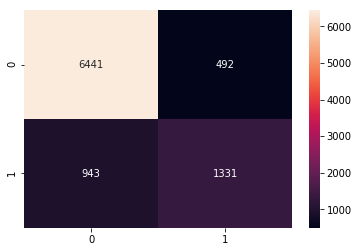

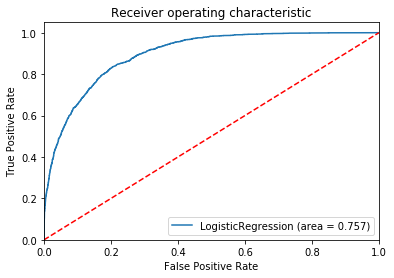

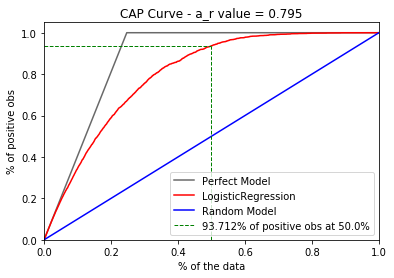

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [268]:
from sklearn.linear_model import LogisticRegression
classify_and_plot(LogisticRegression(solver='liblinear'))

## Decision Tree Classifier

Accuracy is: 0.814
F1 Score is: 0.620
              precision    recall  f1-score   support

       <=50K       0.87      0.88      0.88      6933
        >50K       0.63      0.61      0.62      2274

   micro avg       0.81      0.81      0.81      9207
   macro avg       0.75      0.75      0.75      9207
weighted avg       0.81      0.81      0.81      9207



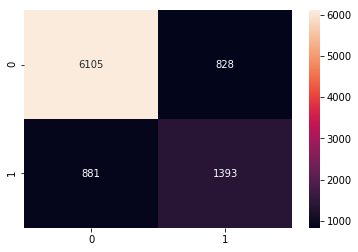

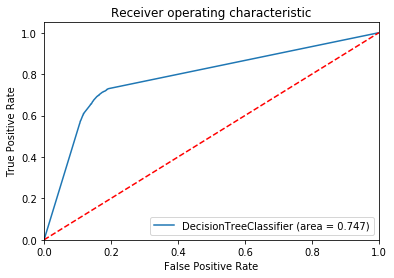

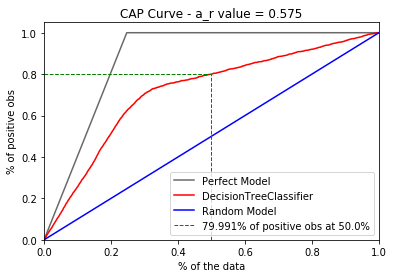

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [252]:
from sklearn.tree import DecisionTreeClassifier
classify_and_plot(DecisionTreeClassifier())

In [250]:
'''
!{sys.executable} -m pip install --quiet pydotplus
from sklearn.externals.six import StringIO  
from sklearn.tree import export_graphviz
import pydotplus

dot_data = StringIO()
export_graphviz(_, out_file=dot_data, filled=True, rounded=True, special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_pdf("tree.pdf")
'''

'\n!{sys.executable} -m pip install --quiet pydotplus\nfrom sklearn.externals.six import StringIO  \nfrom sklearn.tree import export_graphviz\nimport pydotplus\n\ndot_data = StringIO()\nexport_graphviz(_, out_file=dot_data, filled=True, rounded=True, special_characters=True)\ngraph = pydotplus.graph_from_dot_data(dot_data.getvalue())  \ngraph.write_pdf("tree.pdf")\n'

## Random Forest Classifier

Accuracy is: 0.841
F1 Score is: 0.655
              precision    recall  f1-score   support

       <=50K       0.88      0.92      0.90      6933
        >50K       0.70      0.61      0.66      2274

   micro avg       0.84      0.84      0.84      9207
   macro avg       0.79      0.76      0.78      9207
weighted avg       0.84      0.84      0.84      9207



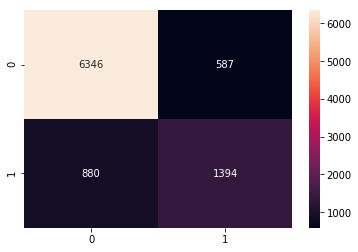

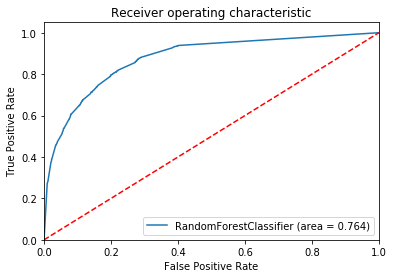

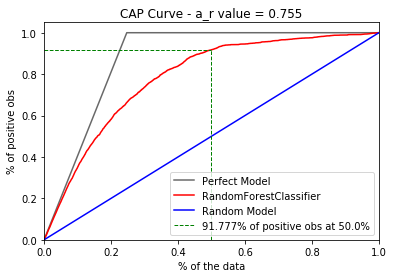

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [182]:
from sklearn.ensemble import RandomForestClassifier
classify_and_plot(RandomForestClassifier(n_estimators=10))

## Gradient Boosted Trees

Accuracy is: 0.847
F1 Score is: 0.675
              precision    recall  f1-score   support

       <=50K       0.89      0.91      0.90      6933
        >50K       0.71      0.64      0.67      2274

   micro avg       0.85      0.85      0.85      9207
   macro avg       0.80      0.78      0.79      9207
weighted avg       0.84      0.85      0.84      9207



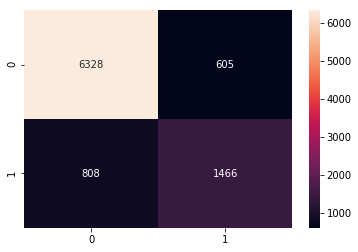

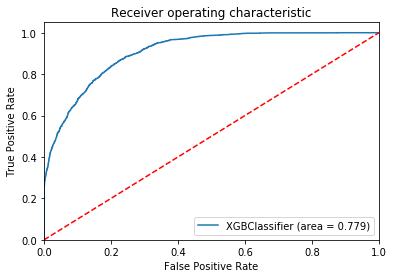

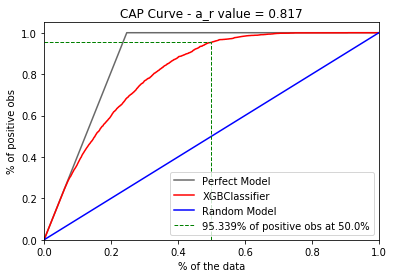

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=100, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [183]:
import xgboost as xkg
classify_and_plot(xkg.XGBClassifier(max_depth=100))

## Naive Bayes Classifier

Accuracy is: 0.822
F1 Score is: 0.670
              precision    recall  f1-score   support

       <=50K       0.91      0.85      0.88      6933
        >50K       0.62      0.73      0.67      2274

   micro avg       0.82      0.82      0.82      9207
   macro avg       0.76      0.79      0.77      9207
weighted avg       0.84      0.82      0.83      9207



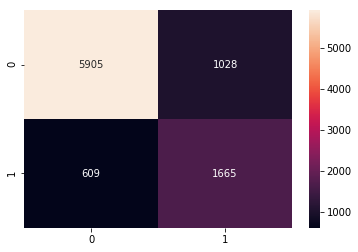

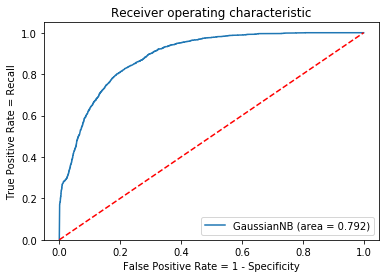

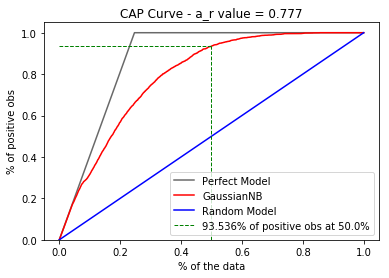

GaussianNB(priors=[0.75, 0.25], var_smoothing=1e-09)

In [278]:
from sklearn.naive_bayes import GaussianNB
classify_and_plot(GaussianNB(priors=[0.75, 0.25]))

Accuracy is: 0.825
F1 Score is: 0.674
              precision    recall  f1-score   support

       <=50K       0.91      0.86      0.88      6933
        >50K       0.62      0.73      0.67      2274

   micro avg       0.82      0.82      0.82      9207
   macro avg       0.77      0.79      0.78      9207
weighted avg       0.84      0.82      0.83      9207



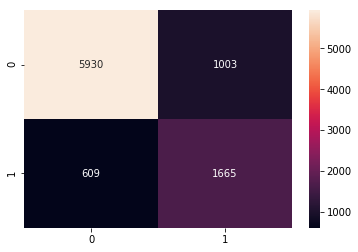

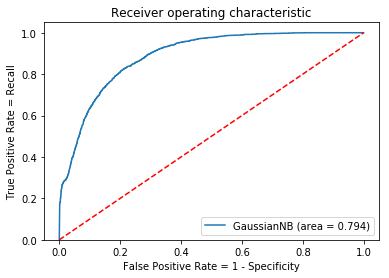

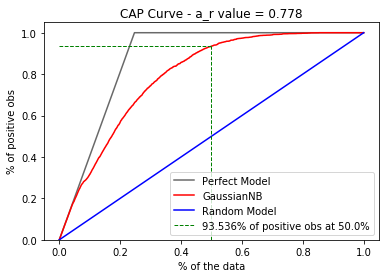

GaussianNB(priors=[0.75, 0.25], var_smoothing=1e-09)

In [279]:
classify_and_plot(GaussianNB(priors=[0.75, 0.25]), True)

# Neural Networks

## Multi-Layer Perceptron

In [219]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers.advanced_activations import LeakyReLU
from keras.wrappers.scikit_learn import KerasClassifier

import tensorflow as tf
import keras_metrics


In [272]:
def create_model():
    model = Sequential()
    model.add(Dense(40, kernel_initializer='normal', input_dim=80))
    model.add(LeakyReLU(alpha=0.001))
    model.add(Dropout(0.1))
    model.add(Dense(20, kernel_initializer='normal'))
    model.add(LeakyReLU(alpha=0.001))
    model.add(Dropout(0.1))
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[
        'accuracy', 
        keras_metrics.precision(), 
        keras_metrics.recall()
    ])
    return model

In [273]:
estimators = []
estimators.append(('scaler', StandardScaler()))
estimators.append(('mlp', KerasClassifier(build_fn=create_model, epochs=100, batch_size=5, verbose=1, validation_data=(X_test, y_test==">50K"))))
pipeline = Pipeline(estimators)

c:\portableapps\winpython\python-3.7.0.amd64\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
c:\portableapps\winpython\python-3.7.0.amd64\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Train on 36826 samples, validate on 9207 samples
Epoch 1/100
36826/36826 [==============================] - 11s 292us/step - loss: 0.3457 - acc: 0.8383 - precision: 0.7202 - recall: 0.5709 - val_loss: 3.5228 - val_acc: 0.2763 - val_precision: 0.2538 - val_recall: 0.9947
Epoch 2/100
36826/36826 [==============================] - 11s 302us/step - loss: 0.3262 - acc: 0.8486 - precision: 0.7482 - recall: 0.5888 - val_loss: 1.8548 - val_acc: 0.4315 - val_precision: 0.2749 - val_recall: 0.7951
Epoch 3/100
36826/36826 [==============================] - 11s 306us/step - loss: 0.3232 - acc: 0.8495 - precision: 0.7455 - recall: 0.5984 - val_loss: 1.5591 - val_acc: 0.7542 - val_precision: 0.5039 - val_recall: 0.3140
Epoch 4/100
36826/36826 [==============================] - 12s 313us/step - loss: 0.3208 - acc: 0.8501 - precision: 0.7480 - recall: 0.5983 - val_loss: 1.5649 - val_acc: 0.7545 - val_precision: 0.5049 - val_recall: 0.3162
Epoch 5/100
36826/36826 [==============================] - 11s 

36826/36826 [==============================] - 20s 539us/step - loss: 0.3037 - acc: 0.8620 - precision: 0.7730 - recall: 0.6294 - val_loss: 1.3247 - val_acc: 0.7771 - val_precision: 0.5927 - val_recall: 0.3122
Epoch 38/100
36826/36826 [==============================] - 20s 553us/step - loss: 0.3038 - acc: 0.8627 - precision: 0.7774 - recall: 0.6267 - val_loss: 1.3265 - val_acc: 0.7771 - val_precision: 0.5927 - val_recall: 0.3122
Epoch 39/100
36826/36826 [==============================] - 21s 563us/step - loss: 0.3037 - acc: 0.8628 - precision: 0.7717 - recall: 0.6357 - val_loss: 1.5710 - val_acc: 0.7771 - val_precision: 0.5927 - val_recall: 0.3122
Epoch 40/100
36826/36826 [==============================] - 21s 558us/step - loss: 0.3027 - acc: 0.8642 - precision: 0.7775 - recall: 0.6352 - val_loss: 1.4917 - val_acc: 0.7771 - val_precision: 0.5927 - val_recall: 0.3122
Epoch 41/100
36826/36826 [==============================] - 21s 574us/step - loss: 0.3035 - acc: 0.8612 - precision: 0.77

Epoch 74/100
36826/36826 [==============================] - 13s 340us/step - loss: 0.2961 - acc: 0.8654 - precision: 0.7794 - recall: 0.6393 - val_loss: 1.7229 - val_acc: 0.7771 - val_precision: 0.5927 - val_recall: 0.3122
Epoch 75/100
36826/36826 [==============================] - 12s 331us/step - loss: 0.2977 - acc: 0.8663 - precision: 0.7819 - recall: 0.6407 - val_loss: 3.0153 - val_acc: 0.7771 - val_precision: 0.5927 - val_recall: 0.3122
Epoch 76/100
36826/36826 [==============================] - 12s 326us/step - loss: 0.2976 - acc: 0.8659 - precision: 0.7794 - recall: 0.6418 - val_loss: 2.0132 - val_acc: 0.7771 - val_precision: 0.5927 - val_recall: 0.3122
Epoch 77/100
36826/36826 [==============================] - 13s 341us/step - loss: 0.2954 - acc: 0.8659 - precision: 0.7809 - recall: 0.6395 - val_loss: 2.3368 - val_acc: 0.7771 - val_precision: 0.5927 - val_recall: 0.3122
Epoch 78/100
36826/36826 [==============================] - 14s 369us/step - loss: 0.2972 - acc: 0.8661 - pr

c:\portableapps\winpython\python-3.7.0.amd64\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


9207/9207 [==============================] - 1s 133us/step
Accuracy is: 0.851
F1 Score is: 0.665
              precision    recall  f1-score   support

       <=50K       0.88      0.93      0.90      6933
        >50K       0.75      0.60      0.67      2274

   micro avg       0.85      0.85      0.85      9207
   macro avg       0.81      0.77      0.78      9207
weighted avg       0.84      0.85      0.85      9207



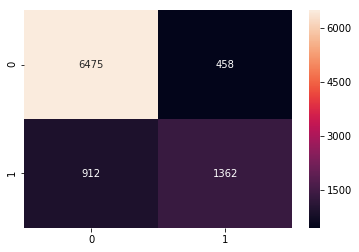

1480/9207 [===>..........................] - ETA: 0s

c:\portableapps\winpython\python-3.7.0.amd64\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


1685/9207 [====>.........................] - ETA: 0s

c:\portableapps\winpython\python-3.7.0.amd64\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


9207/9207 [==============================] - 1s 90us/step


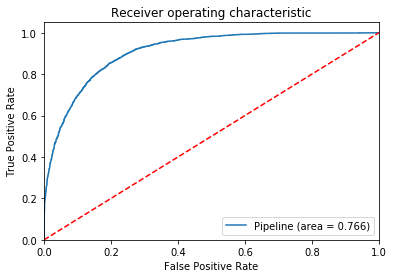

1675/9207 [====>.........................] - ETA: 0s

c:\portableapps\winpython\python-3.7.0.amd64\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


9207/9207 [==============================] - 1s 91us/step


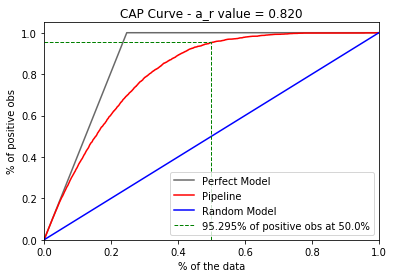

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('mlp', <keras.wrappers.scikit_learn.KerasClassifier object at 0x000002536CCAC278>)])

In [274]:
classify_and_plot(pipeline, True)